In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [3]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

D:\Spark\spark-3.3.1-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
df = spark.read \
    .option("header", "True")\
    .option("InferSchema", "True")\
    .option("sep", ";")\
    .csv('D:/OklahomaState_GradSchool/Courses/22_03_FALL_BAN_5753/Mini_Project_2/XYZ_Bank_Deposit_Data_Classification.csv')

In [5]:
df = df.toDF(*(c.replace('.', '_') for c in df.columns))
df.toPandas().head(4)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
str_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
print("Total catagorical Columns: " , len(str_cols))
print(str_cols)

dbl_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, DoubleType) | isinstance(f.dataType, IntegerType)]
print("Total numerical Columns: ", len(dbl_cols))
print(dbl_cols)

Total catagorical Columns:  11
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
Total numerical Columns:  10
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']


In [7]:
for col in df.columns:
    print(col, ":\n ", df.filter(df[col]=="?").count(), "null values\n ", df.select(col).distinct().count(), " distinct values")
    print

age :
  0 null values
  78  distinct values
job :
  0 null values
  12  distinct values
marital :
  0 null values
  4  distinct values
education :
  0 null values
  8  distinct values
default :
  0 null values
  3  distinct values
housing :
  0 null values
  3  distinct values
loan :
  0 null values
  3  distinct values
contact :
  0 null values
  2  distinct values
month :
  0 null values
  10  distinct values
day_of_week :
  0 null values
  5  distinct values
duration :
  0 null values
  1544  distinct values
campaign :
  0 null values
  42  distinct values
pdays :
  0 null values
  27  distinct values
previous :
  0 null values
  8  distinct values
poutcome :
  0 null values
  3  distinct values
emp_var_rate :
  0 null values
  10  distinct values
cons_price_idx :
  0 null values
  26  distinct values
cons_conf_idx :
  0 null values
  26  distinct values
euribor3m :
  0 null values
  316  distinct values
nr_employed :
  0 null values
  11  distinct values
y :
  0 null values
  2  di

In [8]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [9]:
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp_var_rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [10]:

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
     stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
     encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
     stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
numericCols = ['pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features", handleInvalid="skip") # use setHandleInvalid("skip")
stages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

cols = df.columns
print(cols)
print(stages)

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']
[StringIndexer_3b156469f7fa, OneHotEncoder_8dc02100ddb3, StringIndexer_eab741fa6696, OneHotEncoder_0e68adb431d9, StringIndexer_c0ea6f33470c, OneHotEncoder_25ae1fba5d05, StringIndexer_232222dc04d1, OneHotEncoder_1319c9525799, StringIndexer_e3837420afc2, OneHotEncoder_2505f56606e2, StringIndexer_ed49f1451a06, OneHotEncoder_fc29c0ce8960, StringIndexer_c02109ab2807, OneHotEncoder_d529ca13ac17, StringIndexer_60f1b54c94d4, OneHotEncoder_1cae7682ba25, StringIndexer_cf7a1138bb09, OneHotEncoder_3f023dc2819a, StringIndexer_372a1881409e, OneHotEncoder_2df4e0885cf5, StringIndexer_9937e69e12ca, VectorAssembler_12902ecffef8, StandardScaler_3a6b2e200bd2]


In [11]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)

print(df.toPandas().head())

   label                                           features  age        job  \
0    0.0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.315...   56  housemaid   
1    0.0  (0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, ...   57   services   
2    0.0  (0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, ...   37   services   
3    0.0  (2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   40     admin.   
4    0.0  (0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, ...   56   services   

   marital    education  default housing loan    contact  ... campaign pdays  \
0  married     basic.4y       no      no   no  telephone  ...        1   999   
1  married  high.school  unknown      no   no  telephone  ...        1   999   
2  married  high.school       no     yes   no  telephone  ...        1   999   
3  married     basic.6y       no      no   no  telephone  ...        1   999   
4  married  high.school       no      no  yes  telephone  ...        1   999   

   previous     poutcome  emp_var_rate  cons

In [12]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(df)
data_scale_output=data_scale.transform(df)
data_scale_output.show(2)

+-----+--------------------+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+--------------------+
|label|            features|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|        standardized|
+-----+--------------------+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+--------------------+
|  0.0|(49,[8,11,18,21,2...| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|(49,[8,11,18,21,2...|
|  0.0|(49,[3,11

In [13]:
train, test = data_scale_output.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


In [14]:
train.groupby("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|29185|
|yes| 3709|
+---+-----+



In [15]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,25):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(train)
    output=KMeans_fit.transform(test)
    
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Nbr Of Clusters:",i, " Silhouette Score:",score)

Nbr Of Clusters: 2  Silhouette Score: 0.2152824197556459
Nbr Of Clusters: 3  Silhouette Score: 0.07846837462116232
Nbr Of Clusters: 4  Silhouette Score: 0.10981259128877748
Nbr Of Clusters: 5  Silhouette Score: 0.08108610690722912
Nbr Of Clusters: 6  Silhouette Score: 0.1159929672506733
Nbr Of Clusters: 7  Silhouette Score: 0.12245356017486403
Nbr Of Clusters: 8  Silhouette Score: 0.12851276437390644
Nbr Of Clusters: 9  Silhouette Score: 0.13579252143953735
Nbr Of Clusters: 10  Silhouette Score: 0.10491053446485711
Nbr Of Clusters: 11  Silhouette Score: 0.12587870025614323
Nbr Of Clusters: 12  Silhouette Score: 0.1259299565936076
Nbr Of Clusters: 13  Silhouette Score: 0.11550206760228626
Nbr Of Clusters: 14  Silhouette Score: 0.13592545183466306
Nbr Of Clusters: 15  Silhouette Score: 0.126705034212877
Nbr Of Clusters: 16  Silhouette Score: 0.12622097569440222
Nbr Of Clusters: 17  Silhouette Score: 0.1576237257408727
Nbr Of Clusters: 18  Silhouette Score: 0.15622694356740197
Nbr Of Clus

Text(0, 0.5, 'cost')

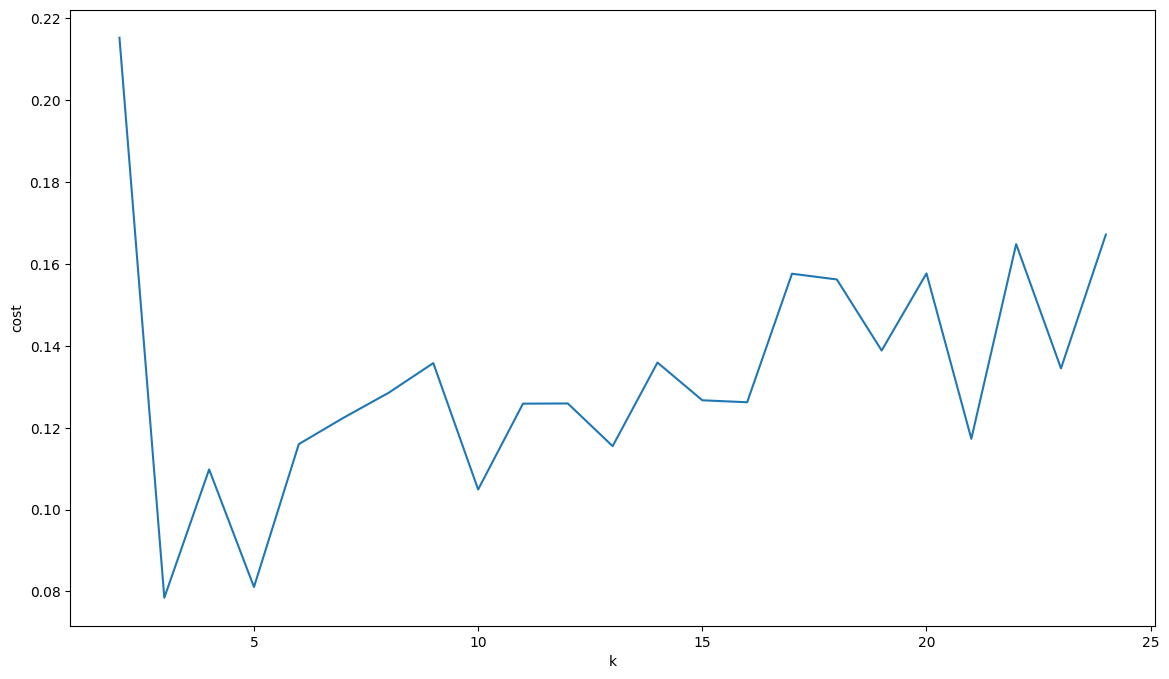

In [21]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(14,8))
ax.plot(range(2,25),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [25]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=9, seed=1)
model = kmeans.fit(test.select('features'))
transformed = model.transform(test)

In [26]:
transformed.show(5)

+-----+--------------------+---+------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+--------------------+----------+
|label|            features|age|   job|marital|        education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|        standardized|prediction|
+-----+--------------------+---+------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+--------------------+----------+
|  0.0|(49,[0,11,14,21,2...| 29|admin.|married|university.degree|     no|    yes|  no|cellular|  jul|        thu|      51|       1|  999|       0|nonexistent|         1.4|        93.918|        -42.7|    4.958|     5228.1| 

In [27]:
transformed.groupBy("prediction").count().orderBy("prediction").show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 1209|
|         1| 1235|
|         2| 2197|
|         3|  169|
|         4|  148|
|         5|  685|
|         6|  237|
|         7|  109|
|         8| 2305|
+----------+-----+

